Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/Python
darnn_network_modified.py  moving_window_tests_mod_dec17.py  title.jpg
darnn_network_russia.py    moving_window_tests_mod_dec28.py  utils.py
error_metrics_2020.py      moving_window_tests.py
error_metrics.py           __pycache__/


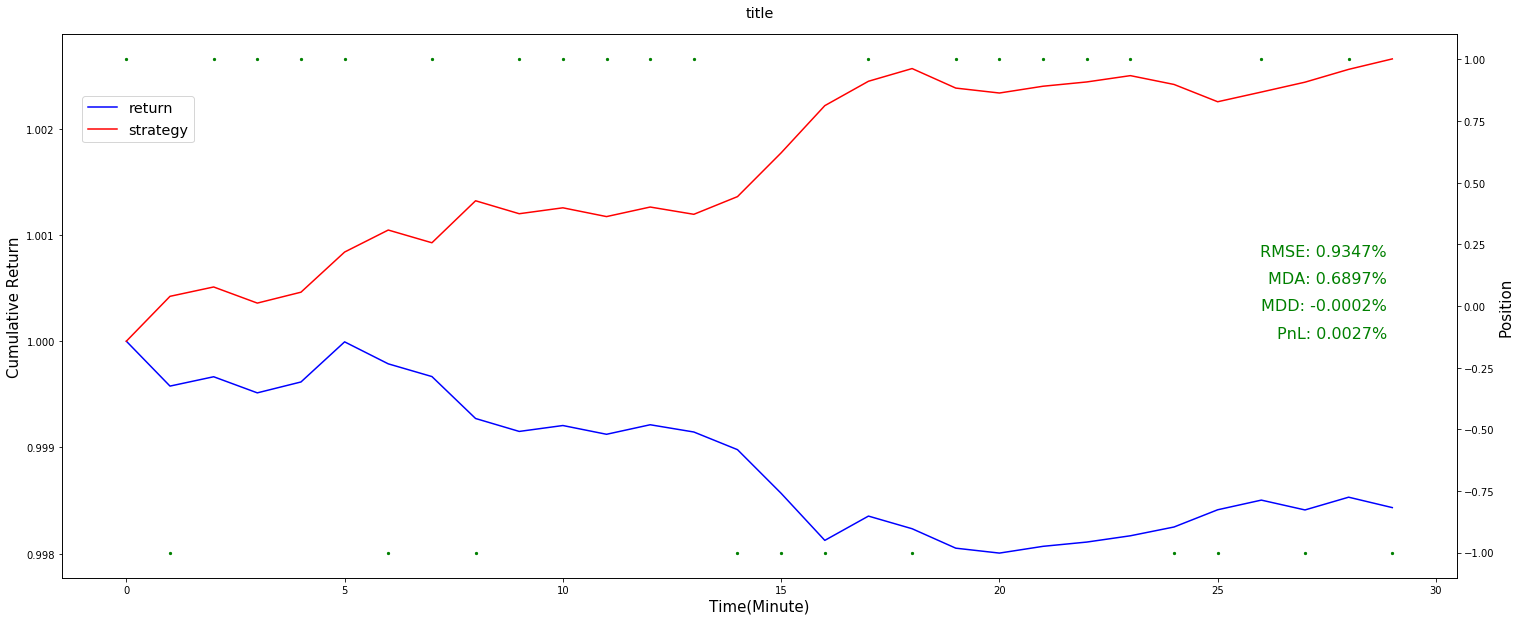

save plots ... 
SR_Annualized:  2.766880413012375
R2:  0.9138308362020657
/content/drive/My Drive/Colab Notebooks/Data
attention2.txt                         LR_best.txt
attention3.txt                         nasdaq100_padding.csv
attention4.txt                         OLS_best.txt
attention_diff.txt                     ols_err_ndx
attention_my_loss2.txt                 ols_pred_list.txt
attention_my_loss.txt                  PCA_best.txt
attention_reest.txt                    PLS_best.txt
attention.txt                          RFR_best.txt
darnn_colab_ndx_last.pt                rfr_err_ndx_n
darnn_colab_ndx_more_patient2.pt       rfr_pred_n.txt
darnn_colab_ndx_more_patient3.pt       rfr_score_n.txt
darnn_colab_ndx_more_patient4.pt       RR_best.txt
darnn_colab_ndx_more_patient_last2.pt  temporal2.txt
darnn_colab_ndx_more_patient_last3.pt  temporal3.txt
darnn_colab_ndx_more_patient_last4.pt  temporal4.txt
darnn_colab_ndx_more_patient_last.pt   temporal_diff.txt
darnn_colab_ndx_more_pat

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import pickle
from fastai import *
pd.set_option('display.float_format', lambda x: '%.4f' % x)

from google.colab import drive
drive.mount('/content/drive')

%cd "/content/drive/My Drive/Colab Notebooks/Python"
%ls
from error_metrics_2020 import *
#from moving_window_tests_mod_dec17 import *
#from utils import *

%cd "/content/drive/My Drive/Colab Notebooks/Data"
%ls
# Dataset is now stored in a Pandas Dataframe.
data = pd.read_csv("nasdaq100_padding.csv")
data.shape

%matplotlib inline
np.set_printoptions(suppress=True)
pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',1000)
warnings.filterwarnings(action='ignore')

In [ ]:
# Save files here
%cd "/content/drive/My Drive/Colab Notebooks/Result/Baseline"

/content/drive/My Drive/Colab Notebooks/Result/Baseline


In [ ]:
import pandas as pd
import numpy as np
import time
import os
import warnings
import pickle
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression, PLSSVD

from sklearn.model_selection import GridSearchCV 
from sklearn.pipeline import Pipeline

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression #F-value between label/feature for regression tasks.

from statsmodels.tsa.api import VAR
from xgboost import XGBRegressor
pd.options.mode.chained_assignment = None  # default='warn'
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
def get_data_split(data_ready, lookback, test_length):
    
    data = data_ready.iloc[-test_length-lookback:,:]
    length = data.shape[0]
    train_starts = np.arange(0, length - lookback,1)
    # to make the train_starts and test_starts have the same number of elements
    test_starts = np.arange(lookback, length + 1, 1)[:len(train_starts)] 
    trains = [data.iloc[s:s+lookback] for s in train_starts]
    tests = [data.iloc[s:s+1] for s in test_starts]
    print('Split Done. Train Start')
    #print('training set len:', len(trains))
    #print('test set len:', len(tests))
    return trains, tests

In [ ]:
def get_lag_diff(raw_data, order, target, exo=True):
    p = order - 1 
    X = raw_data.copy()
    # Generate lag variables 
    composite_col = X.columns[X.columns != target]
    X['y_pch'] = X[target].diff()
    X['y_pch_true'] = X['y_pch'].shift(-1)

    if exo:
        X[composite_col + '_pch'] = X[composite_col].diff()
        # make lag p variables and drop
        for i in range(0, p):
            X['y_pch_' + str(i+1)] = X['y_pch'].shift(i+1)
            X[composite_col + ('_' + str(i+1))] = X[composite_col + '_pch'].shift(i+1)      
    else:
        for i in range(0, p):
            X['y_pch_' + str(i+1)] = X['y_pch'].shift(i+1)

    # drop price series
    # don't drop target because we need to compare later
    X.drop(columns=composite_col, inplace=True) 
    X.dropna(inplace=True)
    print('Lag %d Diff Generated' %order)
    return X

In [ ]:
def get_moving_pred(raw_data, order, test_length, target, exo=True):
    X = raw_data.copy()

    # generate diff and its lag variables
    data = get_lag_diff(X, 1, target)

    # dict for models    
    params_ols = {'fit_intercept': [True, False]}
    params_rl = {'alpha':[0.01, 0.05, 0.1, 0.3, 0.5, 1, 5, 10, 20, 100, 200, 300]}
    params_dim = {'n_components': [2,3,5,10,20]}
    params_rfr = {'n_estimators':[10, 30],
               'max_depth':[5,20],
               'min_samples_leaf' :[1,10],
               'max_leaf_nodes' :[5,15]
               }
    params_xgr = {'n_estimators': [30, 50],
              'min_child_weight': [50, 100],
              'gamma': [0],
              'subsample': [0.8],
              'colsample_bytree': [0.8, 1],
              'max_depth': [5]
              }
    models = {
            'XGR': GridSearchCV(XGBRegressor(objective='reg:squarederror'),
                                param_grid=params_xgr, iid='deprecated', cv=3),
            'RFR': GridSearchCV(RandomForestRegressor(), 
                               param_grid=params_rfr, iid='deprecated', cv=3),
            'OLS': GridSearchCV(LinearRegression(), 
                               param_grid=params_ols, iid='deprecated', cv=5),
            'LR': GridSearchCV(Lasso(), 
                               param_grid=params_rl, iid='deprecated', cv=5),
            'RR': GridSearchCV(Ridge(), 
                               param_grid=params_rl, iid='deprecated', cv=5),
            'PLS': GridSearchCV(PLSRegression(), 
                               param_grid=params_dim, iid='deprecated', cv=5),
            'PCA': GridSearchCV(LinearRegression(), 
                               param_grid=params_ols, iid='deprecated', cv=5)
            }

    pred_result = {}
    df_err_model = pd.DataFrame([])
    lookback1 = [30, 50, 100, 500, 1000, 3000, 6000, 10000, 12000, 15000]
    lookback2 = [10000, 12000, 15000]
    pca_num = np.array([])
    
    for m in models:
        
        min_score = -100000
        print('Model %s Start' %m)
        pred_price_best = np.array([])
        if m =='XGR' or m == 'RFR':
            lookback = lookback2
        else:
            lookback = lookback1
            
        for n in lookback:

            # split the data with different lookback n
            trains, tests = get_data_split(data_ready = data, lookback = n, test_length = test_length)
            print('Lookback : %d' %n)

            pred_price = np.array([])
            
            true_price = np.array([])

            for i in range(len(trains)):
                
                iteration_start = time.monotonic()
                X_train = trains[i].drop(columns=['y_pch_true', target])
                X_test = tests[i].drop(columns=['y_pch_true', target])
                Y_train = trains[i]['y_pch_true']
                   
                if m == 'PLS':
                    X_train_mean = np.mean(X_train, axis=0)
                    X_train = X_train-X_train_mean
                    X_test = tests[i].drop(columns=['y_pch_true', target]).values - X_train_mean[np.newaxis,:] # centered for test set
                    model_fit = models[m].fit(X_train, Y_train) # PLS.fit(X)
                    selected_params = model_fit.best_params_
                    best_model = model_fit.best_estimator_
                    pred_diff = best_model.predict(X_test) # we dont have to do: np.matmul(X_test, X_pls.x_loadings_)
                
                elif m == 'PCA':
                    X_train_mean = np.mean(X_train, axis=0)
                    X_train = X_train-X_train_mean # centered
                    X_test = tests[i].drop(columns=['y_pch_true', target]).values - X_train_mean[np.newaxis,:] # centered for test set
                    
                    # select best n_component for each train set
                    pca_min_score = 100000000
                    
                  
                    for j in [2,3,5,10,20,30]:
                        pca_fit = PCA(n_components=j).fit(X_train)
                        model_fit = models[m].fit(pca_fit.fit_transform(X_train), Y_train) # OLS.fit on selected PCs
                        selected_params = model_fit.best_params_
                        best_model = model_fit.best_estimator_
                        pred_diff_pca = best_model.predict(np.matmul(X_test, np.transpose(pca_fit.components_))) # loadings
                        pca_score = mse(trains[i]['y_pch_true'].iloc[-1:].values, pred_diff_pca)
                        
                        # update whenevere mse gets smaller
                        if pca_score < pca_min_score:
                            pca_min_score = pca_score
                            pred_diff = pred_diff_pca
                            best_j = j
                    pca_num = np.append(pca_num, best_j)
                    #print('PCA choose %d' %pca_num)

                else:
                    model_fit = models[m].fit(X_train, Y_train)
                    selected_params = model_fit.best_params_
                    best_model = model_fit.best_estimator_
                    #print('best model selected')
                    X_new = SelectFromModel(estimator = best_model, threshold='median').fit(X_train,Y_train)
                    #print('best input selected')
                    best_model.fit(X_new.transform(X_train),Y_train)
                    selected_col = X_train.columns[X_new.get_support()]
                    pred_diff = best_model.predict(X_test[selected_col].values)
                
                
                # recover price using predicted difference after feature selection
                true_price = np.append(true_price, trains[i][target].iloc[-1:].values+ trains[i]['y_pch_true'].iloc[-1:].values)
                pred_price = np.append(pred_price, trains[i][target].iloc[-1:].values + pred_diff)
                #print(selected_params)
                iteration_end = time.monotonic()
                if(i % 499 == 1):
                    print('{:.2f}%'.format(i/(len(trains)+1)*100))
                    print("Iter time of %s: " %m, iteration_end - iteration_start)
                    print(selected_params)
            err_metric = evaluate(true_price, pred_price)
            score = err_metric['mda']

            if min_score < score:
                
                print("Saving... Score: %f for lookback: %d " %(score, n))
                fname = str(m)+'_best.txt'
                f = [true_price, pred_price, n, selected_params]
                with open(fname,"wb") as fp:
                    pickle.dump(f,fp)
                pred_price_best = pred_price
                min_score = score
                backtesting(true_price, pred_price, title = str(m)+'_lookback_'+str(n)+'_on_'+str(test_length))
            
            # save every model with every lookback
            fname2 = str(m)+'_'+str(n)+'.txt'
            f2 = pred_price
            with open(fname2, "wb") as fp:
                pickle.dump(f2,fp)
            
            
            df = pd.DataFrame(err_metric.items())
            df = df.transpose()
            df.columns = df.iloc[0]
            df = df.drop(df.index[[0]]).astype(float) # change to float to use round(3)
            df['lookback']=str(n)
            df['model']=str(m)
            #df.columns = [str(col) + '_' + str(m) for col in df.columns]
            df_err_model = df_err_model.append(df, ignore_index = True)
            print(df_err_model)
            fname3 = 'df_err_model.txt'
            with open(fname3,"wb") as fp:
                pickle.dump(df_err_model,fp)

        fname4 = 'pca_num.txt'
        with open(fname4,"wb") as fp:
            pickle.dump(pca_num,fp)

        pred_result[m] = pred_price_best
        print(pred_price_best.shape)
        evaluate(true_price, pred_price_best)

    return  true_price, df_err_model

In [ ]:
true_price, df_err_model = get_moving_pred(data, 1, 1000, 'NDX')

# XGB and RFR

Lag 1 Diff Generated
Model XGR Start
Split Done. Train Start
Lookback : 500
0.10%
Iter time of XGR:  1.5779529569999795
{'colsample_bytree': 0.8, 'gamma': 0, 'max_depth': 5, 'min_child_weight': 100, 'n_estimators': 30, 'subsample': 0.8}
49.95%
Iter time of XGR:  1.6552448329999834
{'colsample_bytree': 1, 'gamma': 0, 'max_depth': 5, 'min_child_weight': 100, 'n_estimators': 30, 'subsample': 0.8}
99.80%
Iter time of XGR:  1.6020032590001847
{'colsample_bytree': 1, 'gamma': 0, 'max_depth': 5, 'min_child_weight': 100, 'n_estimators': 30, 'subsample': 0.8}
Saving... Score: 0.673674 for lookback: 500 


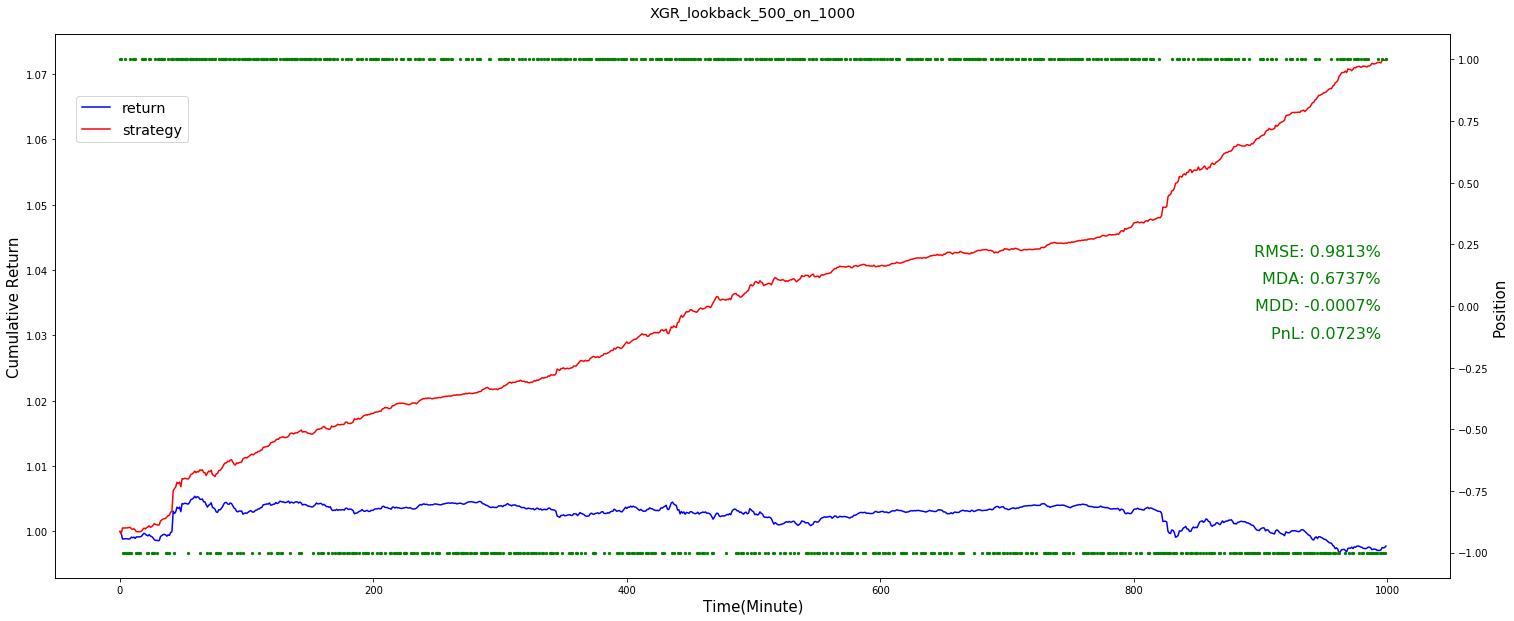

save plots ... 
SR_Annualized:  2.106307748027593
R2:  0.9880003848516999
0   rmse    mda   mpda   mnda    mpp    mnp lookback model
0 0.9813 0.6737 0.7276 0.6213 0.6509 0.7016      500   XGR
Split Done. Train Start
Lookback : 1000
0.10%
Iter time of XGR:  3.6572679150001477
{'colsample_bytree': 0.8, 'gamma': 0, 'max_depth': 5, 'min_child_weight': 100, 'n_estimators': 30, 'subsample': 0.8}
49.95%
Iter time of XGR:  3.7338818809998884
{'colsample_bytree': 1, 'gamma': 0, 'max_depth': 5, 'min_child_weight': 100, 'n_estimators': 30, 'subsample': 0.8}
99.80%
Iter time of XGR:  3.7668334370000593
{'colsample_bytree': 1, 'gamma': 0, 'max_depth': 5, 'min_child_weight': 100, 'n_estimators': 30, 'subsample': 0.8}
0   rmse    mda   mpda   mnda    mpp    mnp lookback model
0 0.9813 0.6737 0.7276 0.6213 0.6509 0.7016      500   XGR
1 0.9795 0.6517 0.7073 0.5976 0.6304 0.6779     1000   XGR
Split Done. Train Start
Lookback : 3000
0.10%
Iter time of XGR:  10.672864226999991
{'colsample_bytree': 1, 'g

In [ ]:
true_price, df_err_model = get_moving_pred(data,1, 1000, 'NDX')

Lag 1 Diff Generated
Model XGR Start
Split Done. Train Start
Lookback : 10000
0.10%
Iter time of XGR:  27.654244557999988
{'colsample_bytree': 1, 'gamma': 0, 'max_depth': 5, 'min_child_weight': 100, 'n_estimators': 30, 'subsample': 0.8}
49.95%
Iter time of XGR:  27.841118774998904
{'colsample_bytree': 1, 'gamma': 0, 'max_depth': 5, 'min_child_weight': 100, 'n_estimators': 30, 'subsample': 0.8}
99.80%
Iter time of XGR:  27.770533947998047
{'colsample_bytree': 1, 'gamma': 0, 'max_depth': 5, 'min_child_weight': 100, 'n_estimators': 30, 'subsample': 0.8}
Saving... Score: 0.682683 for lookback: 10000 


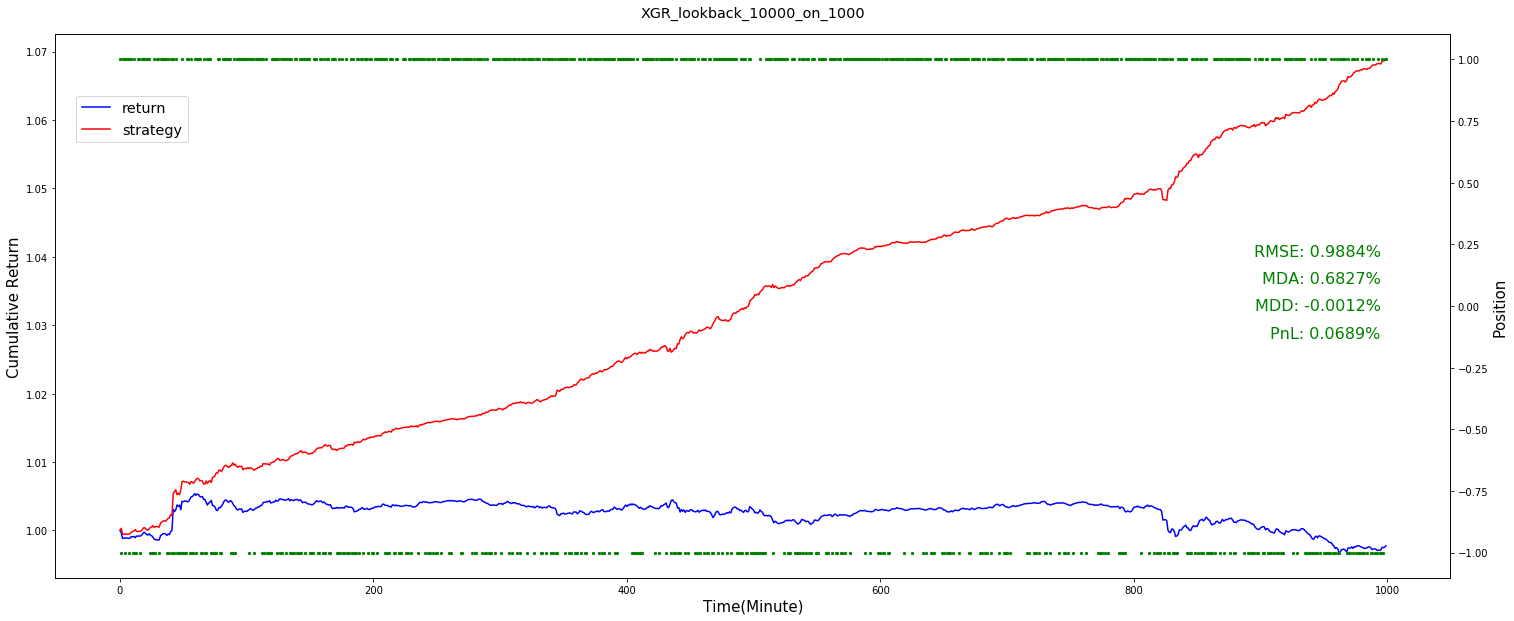

save plots ... 
SR_Annualized:  1.9802507810918955
R2:  0.9878271133804927
0   rmse    mda   mpda   mnda    mpp    mnp lookback model
0 0.9884 0.6827 0.8114 0.5573 0.6410 0.7520    10000   XGR
Split Done. Train Start
Lookback : 12000
0.10%
Iter time of XGR:  32.113371577997896
{'colsample_bytree': 0.8, 'gamma': 0, 'max_depth': 5, 'min_child_weight': 100, 'n_estimators': 30, 'subsample': 0.8}


In [ ]:
true_price, df_err_model = get_moving_pred(data,1, 1000, 'NDX')

In [ ]:
with open('OLS_best.txt',"rb") as fp:
    OLS_best = pickle.load(fp)
with open('LR_best.txt',"rb") as fp:
    LR_best = pickle.load(fp)
with open('RR_best.txt',"rb") as fp:
    RR_best = pickle.load(fp)
with open('PLS_best.txt',"rb") as fp:
    PLS_best = pickle.load(fp)
with open('XGR_best.txt',"rb") as fp:
    XGR_best = pickle.load(fp)
with open('RFR_best.txt',"rb") as fp:
    RFR_best = pickle.load(fp) 


In [ ]:
OLS_best[0].shape, OLS_best[1].shape, 

((100,), (100,))

In [ ]:
LR_best[0].shape, LR_best[1].shape, 

((100,), (100,))

In [ ]:
evaluate(OLS_best[0], OLS_best[1])

{'mda': 0.7171717171717171,
 'mnda': 0.7301587301587301,
 'mnp': 0.8070175438596491,
 'mpda': 0.6944444444444444,
 'mpp': 0.5952380952380952,
 'rmse': 1.5248141867180776}

In [ ]:
df_err_model

,rmse,mda,mpda,mnda,mpp,mnp,lookback,model
0,0.8593,0.6061,0.3889,0.7302,0.4516,0.6765,50,PLS
1,0.9152,0.6768,0.4444,0.8095,0.5714,0.7183,100,PLS
2,0.6419,0.9091,0.8056,0.9683,0.9355,0.8971,50,PCA
3,0.6539,0.9293,0.8056,1.0000,1.0000,0.9000,100,PCA
4,1.5248,0.7172,0.6944,0.7302,0.5952,0.8070,50,OLS
5,1.4936,0.5354,0.5000,0.5556,0.3913,0.6604,100,OLS
6,0.8861,0.6869,0.2222,0.9524,0.7273,0.6818,50,LR
7,0.8499,0.7576,0.4722,0.9206,0.7727,0.7532,100,LR
8,0.8803,0.6263,0.4444,0.7302,0.4848,0.6970,50,RR
9,0.9663,0.6162,0.3889,0.7460,0.4667,0.6812,100,RR
